In [852]:
# Import dependencies
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

mongoimport --type csv -d project3 -c emissions --headerline --drop GCB2022v27_MtCO2_flat.csv

mongoimport --type csv -d project3 -c gdp --headerline --drop gdp.csv

mongoimport --type csv -d project3 -c population --headerline --drop world_population.csv

In [853]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [854]:
mongo.list_database_names()

['admin',
 'autosaurus',
 'classDB',
 'config',
 'epa',
 'fruits_db',
 'local',
 'met',
 'petsitly_marketing',
 'project3',
 'uk_food']

In [855]:
db = mongo["project3"]

In [856]:
db.list_collection_names()

['population', 'gdp', 'emissions']

In [857]:
emissions = db["emissions"]
gdp = db["gdp"]
population = db["population"]

In [858]:
pprint(emissions.find_one())

{'Cement': '',
 'Coal': '',
 'Country': 'Afghanistan',
 'Flaring': '',
 'Gas': '',
 'ISO 3166-1 alpha-3': 'AFG',
 'Oil': '',
 'Other': '',
 'Per Capita': '',
 'Total': 0,
 'Year': 1750,
 '_id': ObjectId('66523c4896b122622ff55ef4')}


In [859]:
emissions_query = {"Year" : {"$gte" : 1922}}
emissions_fields = {"Country", "ISO 3166-1 alpha-3", "Year", "Total", "Coal", "Oil", "Gas", "Cement", "Flaring", "Other"}

In [860]:
emissions_df = pd.DataFrame(emissions.find(emissions_query, emissions_fields))

del emissions_df["_id"]

emissions_df = emissions_df.rename(columns= {"ISO 3166-1 alpha-3" : "Code"})

emissions_df = emissions_df.loc[emissions_df["Country"] != "St. Kitts-Nevis-Anguilla"]

emissions_df.head()

,Country,Code,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other
0,Afghanistan,AFG,1922,0,,,,,,
1,Afghanistan,AFG,1923,0,,,,,,
2,Afghanistan,AFG,1924,0,,,,,,
3,Afghanistan,AFG,1925,0,,,,,,
4,Afghanistan,AFG,1927,0,,,,,,


In [861]:
pprint(gdp.find_one())

{'1960': '',
 '1961': '',
 '1962': '',
 '1963': '',
 '1964': '',
 '1965': '',
 '1966': '',
 '1967': '',
 '1968': '',
 '1969': '',
 '1970': '',
 '1971': '',
 '1972': '',
 '1973': '',
 '1974': '',
 '1975': '',
 '1976': '',
 '1977': '',
 '1978': '',
 '1979': '',
 '1980': '',
 '1981': '',
 '1982': '',
 '1983': '',
 '1984': '',
 '1985': '',
 '1986': 405463417.11746,
 '1987': 487602457.746416,
 '1988': 596423607.114715,
 '1989': 695304363.031101,
 '1990': 764887117.194486,
 '1991': 872138715.083799,
 '1992': 958463184.357542,
 '1993': 1082979720.67039,
 '1994': 1245688268.15642,
 '1995': 1320474860.3352,
 '1996': 1379960893.85475,
 '1997': 1531944134.07821,
 '1998': 1665100558.65922,
 '1999': 1722798882.68156,
 '2000': 1873452513.96648,
 '2001': 1920111731.84358,
 '2002': 1941340782.12291,
 '2003': 2021229050.27933,
 '2004': 2228491620.11173,
 '2005': 2330726256.98324,
 '2006': 2424581005.58659,
 '2007': 2615083798.88268,
 '2008': 2745251396.64804,
 '2009': 2498882681.56425,
 '2010': 2390502

In [862]:
gdp_query = {}
gdp_fields = {"Country Name", "Code", "1970", "1980", "1990", "2000", "2010", "2020"}

In [863]:
gdp_df = pd.DataFrame(gdp.find(gdp_query, gdp_fields))

del gdp_df["_id"]

gdp_df.head()

,Country Name,Code,1970,1980,1990,2000,2010,2020
0,Aruba,ABW,,,764887117.194486,1873452513.96648,2390502793.29609,
1,Africa Eastern and Southern,AFE,40315782854.298599,156512735720.641998,212336051488.558014,283952504751.697998,847409491176.197021,920792331527.745972
2,Afghanistan,AFG,1748886595.55556,3641723321.99546,,,15856678596.148001,20116137325.820599
3,Africa Western and Central,AFW,23504608014.6703,112031316716.518005,121802185300.139008,140407973778.931,591582966686.496948,784587603322.865967
4,Angola,AGO,,5934073603.54849,11236275842.7358,9129634978.33773,83799496611.200394,58375976292.967796


In [864]:
pprint(population.find_one())

{'1970 Population': 10752971,
 '1980 Population': 12486631,
 '1990 Population': 10694796,
 '2000 Population': 19542982,
 '2010 Population': 28189672,
 '2015 Population': 33753499,
 '2020 Population': 38972230,
 '2022 Population': 41128771,
 'Area (km²)': 652230,
 'CCA3': 'AFG',
 'Capital': 'Kabul',
 'Continent': 'Asia',
 'Country/Territory': 'Afghanistan',
 'Density (per km²)': 63.0587,
 'Growth Rate': 1.0257,
 'Rank': 36,
 'World Population Percentage': 0.52,
 '_id': ObjectId('665390023c40ae0fc867eb44')}


In [865]:
population_query = {}
population_fields = {"Country/Territory", "CCA3", "Continent", "1970 Population", "1980 Population", "1990 Population", "2000 Population", "2010 Population", "2020 Population"}

In [866]:
population_df = pd.DataFrame(population.find(population_query, population_fields))

del population_df["_id"]

population_df = population_df.rename(columns= {"CCA3" : "Code"})

population_df.head()

,Code,Country/Territory,Continent,2020 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population
0,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971
1,ALB,Albania,Europe,2866849,2913399,3182021,3295066,2941651,2324731
2,DZA,Algeria,Africa,43451666,35856344,30774621,25518074,18739378,13795915
3,ASM,American Samoa,Oceania,46189,54849,58230,47818,32886,27075
4,AND,Andorra,Europe,77700,71519,66097,53569,35611,19860


In [867]:
merged_df = pd.merge(population_df, gdp_df, on="Code", how="inner").merge(emissions_df, on="Code", how="inner")

merged_df.head()

,Code,Country/Territory,Continent,2020 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Country Name,...,2020,Country,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other
0,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1922,0,,,,,,
1,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1923,0,,,,,,
2,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1924,0,,,,,,
3,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1925,0,,,,,,
4,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1927,0,,,,,,


In [868]:
emissions_df_cleaned = pd.DataFrame(merged_df[["Country/Territory", "Code", "Year", "Total", "Coal", "Oil", "Gas", "Cement", "Flaring", "Other"]])

emissions_df_cleaned = emissions_df_cleaned.rename(columns= {"Country/Territory" : "Country"})

emissions_df_cleaned = emissions_df_cleaned.sort_values(["Country", "Year"])

emissions_df_cleaned = emissions_df_cleaned.reset_index(drop=True)

emissions_df_cleaned.head()

,Country,Code,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other
0,Afghanistan,AFG,1922,0,,,,,,
1,Afghanistan,AFG,1923,0,,,,,,
2,Afghanistan,AFG,1924,0,,,,,,
3,Afghanistan,AFG,1925,0,,,,,,
4,Afghanistan,AFG,1926,0,,,,,,


In [869]:
emissions_df_cleaned.dtypes         

Country    object
Code       object
Year        int64
Total      object
Coal       object
Oil        object
Gas        object
Cement     object
Flaring    object
Other      object
dtype: object

In [870]:
emissions_df_cleaned = emissions_df_cleaned.replace('',0)

emissions_df.dtypes

Country    object
Code       object
Year        int64
Total      object
Coal       object
Oil        object
Gas        object
Cement     object
Flaring    object
Other      object
dtype: object

In [871]:
emissions_df_cleaned["Total"] = emissions_df_cleaned["Total"].astype("float")
emissions_df_cleaned["Coal"] = emissions_df_cleaned["Coal"].astype("float")
emissions_df_cleaned["Oil"] = emissions_df_cleaned["Oil"].astype("float")
emissions_df_cleaned["Gas"] = emissions_df_cleaned["Gas"].astype("float")
emissions_df_cleaned["Cement"] = emissions_df_cleaned["Cement"].astype("float")
emissions_df_cleaned["Flaring"] = emissions_df_cleaned["Flaring"].astype("float")
emissions_df_cleaned["Other"] = emissions_df_cleaned["Other"].astype("float")

emissions_df_cleaned.dtypes

Country     object
Code        object
Year         int64
Total      float64
Coal       float64
Oil        float64
Gas        float64
Cement     float64
Flaring    float64
Other      float64
dtype: object

In [872]:
population_df_cleaned = merged_df.drop_duplicates("Code")

population_df_cleaned = population_df_cleaned[["Country/Territory", "Code", "Continent", "1970 Population", "1980 Population", "1990 Population", "2000 Population", "2010 Population", "2020 Population"]]

population_df_cleaned = population_df_cleaned.rename(columns= {"Country/Territory" : "Country"})

population_df_cleaned = population_df_cleaned.sort_values("Country")

population_df_cleaned = population_df_cleaned.reset_index(drop=True)

population_df_cleaned.head()

,Country,Code,Continent,1970 Population,1980 Population,1990 Population,2000 Population,2010 Population,2020 Population
0,Afghanistan,AFG,Asia,10752971,12486631,10694796,19542982,28189672,38972230
1,Albania,ALB,Europe,2324731,2941651,3295066,3182021,2913399,2866849
2,Algeria,DZA,Africa,13795915,18739378,25518074,30774621,35856344,43451666
3,Andorra,AND,Europe,19860,35611,53569,66097,71519,77700
4,Angola,AGO,Africa,6029700,8330047,11828638,16394062,23364185,33428485


In [873]:
population_df_cleaned.dtypes

Country            object
Code               object
Continent          object
1970 Population     int64
1980 Population     int64
1990 Population     int64
2000 Population     int64
2010 Population     int64
2020 Population     int64
dtype: object

In [874]:
gdp_df_cleaned = merged_df.drop_duplicates("Code")

gdp_df_cleaned = gdp_df_cleaned[["Country/Territory", "Code", "Continent", "1970", "1980", "1990", "2000", "2010", "2020"]]

gdp_df_cleaned = gdp_df_cleaned.rename(columns= {"Country/Territory" : "Country"})

gdp_df_cleaned = gdp_df_cleaned.sort_values("Country")

gdp_df_cleaned = gdp_df_cleaned.reset_index(drop=True)

gdp_df_cleaned.head()

,Country,Code,Continent,1970,1980,1990,2000,2010,2020
0,Afghanistan,AFG,Asia,1748886595.55556,3641723321.99546,,,15856678596.148001,20116137325.820599
1,Albania,ALB,Europe,,,2028553750.0,3480355258.04122,11926922828.9911,14887629268.2927
2,Algeria,DZA,Africa,4863487492.65763,42346380830.770798,62048562947.2509,54790392746.193901,161207270185.25,145009181490.619995
3,Andorra,AND,Europe,78619206.085096,446416105.825017,1029048481.88051,1429049198.45218,3449966856.68832,
4,Angola,AGO,Africa,,5934073603.54849,11236275842.7358,9129634978.33773,83799496611.200394,58375976292.967796


In [875]:
gdp_df_cleaned.dtypes

Country      object
Code         object
Continent    object
1970         object
1980         object
1990         object
2000         object
2010         object
2020         object
dtype: object

In [876]:
gdp_df_cleaned = gdp_df_cleaned.replace('',0)

gdp_df_cleaned.dtypes

Country       object
Code          object
Continent     object
1970         float64
1980         float64
1990         float64
2000         float64
2010         float64
2020         float64
dtype: object

In [877]:
gdp_df_cleaned.head()

,Country,Code,Continent,1970,1980,1990,2000,2010,2020
0,Afghanistan,AFG,Asia,1.748887e+09,3.641723e+09,0.000000e+00,0.000000e+00,1.585668e+10,2.011614e+10
1,Albania,ALB,Europe,0.000000e+00,0.000000e+00,2.028554e+09,3.480355e+09,1.192692e+10,1.488763e+10
2,Algeria,DZA,Africa,4.863487e+09,4.234638e+10,6.204856e+10,5.479039e+10,1.612073e+11,1.450092e+11
3,Andorra,AND,Europe,7.861921e+07,4.464161e+08,1.029048e+09,1.429049e+09,3.449967e+09,0.000000e+00
4,Angola,AGO,Africa,0.000000e+00,5.934074e+09,1.123628e+10,9.129635e+09,8.379950e+10,5.837598e+10


In [878]:
countries_df = population_df_cleaned[["Country", "Code", "Continent"]]

countries_df = countries_df.sort_values("Country")

countries_df = countries_df.reset_index(drop=True)

countries_df.head()

,Country,Code,Continent
0,Afghanistan,AFG,Asia
1,Albania,ALB,Europe
2,Algeria,DZA,Africa
3,Andorra,AND,Europe
4,Angola,AGO,Africa


In [879]:
countries_df.dtypes

Country      object
Code         object
Continent    object
dtype: object

In [880]:
emissions_df_cleaned.to_csv("output/emissions.csv", index=False)
population_df_cleaned.to_csv("output/population.csv", index=False)
gdp_df_cleaned.to_csv("output/gdp.csv", index=False)
countries_df.to_csv("output/countries.csv", index=False)

In [881]:
emissions_json = emissions_df_cleaned.to_json(orient="records")
population_json = population_df_cleaned.to_json(orient="records")
gdp_json = gdp_df_cleaned.to_json(orient="records")
countries_json = countries_df.to_json(orient="records")

In [882]:
emissions_parsed = json.loads(emissions_json)
population_parsed = json.loads(population_json)
gdp_parsed = json.loads(gdp_json)
countries_parsed = json.loads(countries_json)

In [883]:
year = 2021
emission_type = "Coal"

In [884]:
top10_df = emissions_df_cleaned.loc[(emissions_df_cleaned["Year"] == year),:]
top10_df = top10_df[["Country", "Code", emission_type]]
top10_df = top10_df.sort_values(by=emission_type, ascending=False)
top10_df = top10_df.head(10)
top10_df = top10_df.reset_index(drop=True)
top10_df

,Country,Code,Coal
0,China,CHN,7955.985419
1,India,IND,1802.311897
2,United States,USA,1002.299987
3,Japan,JPN,418.820499
4,Russia,RUS,380.227147
5,South Africa,ZAF,370.266547
6,Indonesia,IDN,303.153575
7,South Korea,KOR,283.908353
8,Germany,DEU,230.221049
9,Vietnam,VNM,196.518368


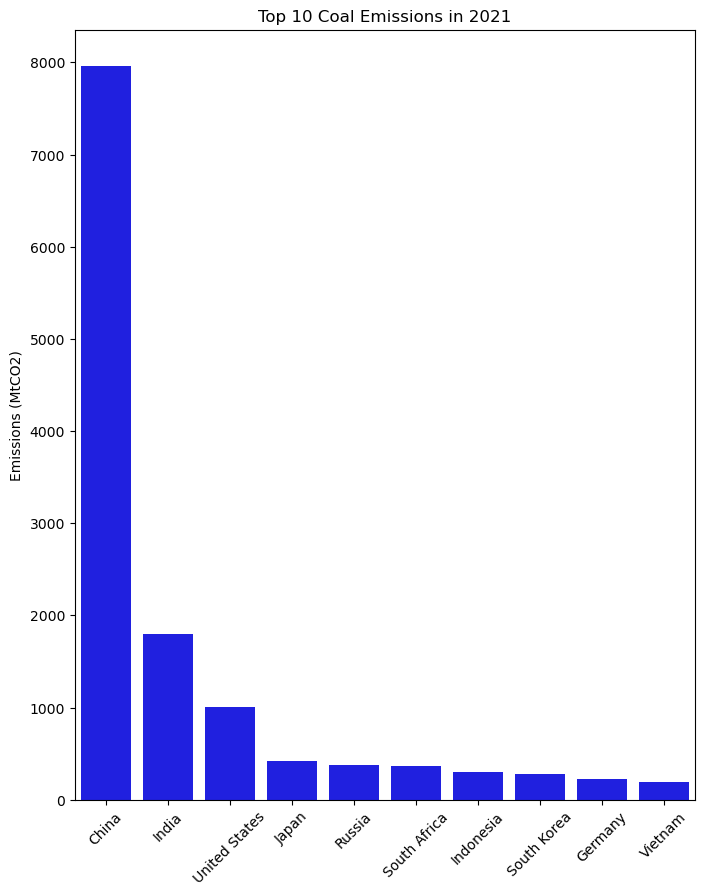

In [937]:
plt.figure(figsize=(8,10))

barplot = sns.barplot(x = top10_df["Country"],
                      y = top10_df[emission_type],
                      color="b")

barplot.set(xlabel="", ylabel = "Emissions (MtCO2)")

barplot.set(title=f'Top 10 {emission_type} Emissions in {year}')

barplot.set_xticklabels(labels = top10_df["Country"], rotation=45)

plt.savefig(f'output/top10_{emission_type.lower()}_emissions_{year}.png', dpi=100)

plt.show()

In [886]:
with open("output/data.json", "w", encoding="utf8") as output:
    output.write(json.dumps({"emissions" : emissions_parsed,
                             "gdp" : gdp_parsed,
                             "population" : population_parsed,
                             "countries" : countries_parsed}, indent=4))